<a href="https://colab.research.google.com/github/sid-betalol/CS6910-FODL-Assignment1/blob/main/cs6910_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To add
1. adding wandb logger
2. breaking the notebook down to scripts based on code implementation instructions
3. early stopping if possible

###**wandb setup**

In [1]:
# !pip install wandb

In [2]:
import wandb

###**Importing the required libraries**


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##**Template Class for Activation Functions**

In [4]:
class daddyActivation():
    def __init__(self, *args, **kwargs):
        """
        Constructor
        """
        self.grads = {}
        self.backprop_cache = {}

    def __call__(self, *args, **kwargs):
        """
        Calling the class as a function instance
        does a forward and a backward pass
        """
        op = self.forward(*args, **kwargs)
        self.grads = self.calc_grads(*args, **kwargs)
        return op

    def forward(self, *args, **kwargs):
        """
        Defining the forward pass of the activation function
        """
        pass
    
    def calc_grads(self, *args, **kwargs):
        """
        Calculates the gradient of the activation function
        with respect to its input
        """
        pass
    
    def backward(self, *args, **kwargs):
        """ 
        Calculates the gradients of the loss with respect 
        to the input of the activation function, using the gradients 
        computed in the calc_grads method
        """
        pass

###**Activation Functions**

In [5]:
class Sigmoid(daddyActivation):
    
    def __init__(self):
        
        super().__init__()

    def forward(self, x):
        
        self.backprop_cache = 1/(1+np.exp(-x))
        return self.backprop_cache

    def calc_grads(self, x):
        
        id = "x"
        y = self.backprop_cache
        diff = y*(1-y)
        return {id:diff}

    def backward(self, y_hat):
        
        return self.grads['x']*y_hat


class Tanh(daddyActivation):
    
    def __init__(self):
        
        super().__init__()

    def forward(self, x):
        
        self.backprop_cache = (np.exp(x) - np.exp(-x))/(np.exp(-x)+np.exp(x))
        return self.backprop_cache

    def calc_grads(self, x):
        
        id = "x"
        y = self.backprop_cache
        diff = 1- y**2
        return {id:diff}

    def backward(self, y_hat):
        
        return self.grads['x']*y_hat


class ReLU(daddyActivation):

    def __init__(self):
        
        super().__init__()

    def forward(self, x):
        
        self.backprop_cache = np.maximum(x, 0.0)
        return self.backprop_cache

    def calc_grads(self,x):
        
        id = "x"
        y = self.backprop_cache
        diff = (y > 0).astype("float")
        return {id:diff}

    def backward(self, y_hat):
        
        return self.grads['x']*y_hat


class LeakyReLU(daddyActivation):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, x):
        self.backprop_cache = np.maximum(x, self.alpha*x)
        return self.backprop_cache
    
    def calc_grads(self, x):
        id = "x"
        y = self.backprop_cache
        diff = np.where(y > 0, 1, self.alpha)
        return {id: diff}
    
    def backward(self, y_hat):
        return self.grads['x']*y_hat

##**Template Class for Loss Functions**

In [6]:
class daddyLoss():
    
    def __init__(self, *args, **kwargs):
        
        self.grads = {}
        self.backprop_cache = {}

    def __call__(self, y_pred, y_true, *args, **kwargs):
        
        op = self.forward(y_pred, y_true, *args, **kwargs)
        self.grads = self.calc_grads(y_pred, y_true, *args, **kwargs)
        return op

    def forward(self, y_pred, y_true, *args, **kwargs):
        
        pass

    def calc_grads(self, y_pred, y_true, *args, **kwargs):
        
        pass

    def backward(self, *args, **kwargs):
        
        return self.grads['x']

###**Helper Functions for Loss (Output Function: Softmax)**

In [7]:
# softmax will be used for the output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis= -1, keepdims=True))
    return exp_x/ np.sum(exp_x, axis = -1, keepdims=True)

###**Loss Functions**

In [8]:
class MSE(daddyLoss):
    
    def __init__(self):
        
        super().__init__()

    def forward(self, y_pred, y_true):
        
        num_classes = y_pred.shape[-1]
        probabs = softmax(y_pred)
        y_true_encoding = np.eye(num_classes, dtype = int)[np.array(y_true).astype(int)]
        self.backprop_cache['y_true'] = y_true_encoding
        loss = np.mean(np.sum((probabs - y_true_encoding)**2, axis=1))
        self.backprop_cache['probabs'] = probabs
        return loss

    def calc_grads(self, y_pred, y_true):
        
        batch_size = y_pred.shape[0]
        grad = 2*(self.backprop_cache["probabs"] - self.backprop_cache["y_true"])
        grad = grad/batch_size
        return {'x': grad}

class LogLoss(daddyLoss):

    def __init__(self):
        
        super().__init__()

    def forward(self, y_pred, y_true):
        
        num_classes = y_pred.shape[-1]
        probabs = softmax(y_pred)
        y_true_encoding = np.eye(num_classes, dtype = int)[np.array(y_true).astype(int)]
        self.backprop_cache['y_true'] = y_true_encoding
        loss = np.mean(- np.log(probabs[np.arange(y_pred.shape[0]), y_true] + 1e-16))
        self.backprop_cache['probabs'] = probabs
        return loss

    def calc_grads(self, y_pred, y_true):
        
        batch_size = y_pred.shape[0]
        grad = self.backprop_cache["probabs"] - self.backprop_cache["y_true"]
        grad = grad/batch_size
        return {'x':grad}

##**Template Class for Optimizers**

In [9]:
class daddyOptimizer():
    
    def __init__(self, *args, **kwargs):
        
        self.history = {}
        pass

    def update_weights(self, layer, *args, **kwargs):
        
        update = self.calc_update(layer)
        for k, v in layer.weights.items():
            layer.weights[k] = layer.weights[k] + update[k]

    def calc_update(self, layer, *args, **kwargs):
        #needs to be overloaded based on the optimizer
        pass

###**Optimizers**
SGD update rule: https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-5#/0/56/7

Momentum Update Rule: https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-5#/0/40/7

NAG Update Rule: https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-5#/0/50/7

Simplied NAG Update Rule: 
1. [ADVANCES IN OPTIMIZING RECURRENT NETWORKS, Bengio et al.](https://arxiv.org/pdf/1212.0901.pdf); 
2. [Sections 7.1 and 7.2 of Ilya Sutskever's PhD. Thesis: TRAINING RECURRENT NEURAL NETWORKS](https://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf); 
3. Brief Mathematical Intuition: [Neural Network Nesterov Momentum by James D. McCaffrey](https://jamesmccaffrey.wordpress.com/2017/07/24/neural-network-nesterov-momentum/);
4. [Various Formulations of NAG](https://jlmelville.github.io/mize/nesterov.html)

RMSProp Update Rule: https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-52#/0/18/5

Adam Update Rule: https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-52#/0/40/10

NAdam Update Rule: https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-52#/0/68

Add a comment to remark about bias correction in Adam/NAdam

Summary of optimizers: https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/

In [10]:
class SGD(daddyOptimizer):

    def __init__(self, learning_rate = 0.001):

        super().__init__()
        self.learning_rate = learning_rate

    def calc_update(self, layer):

        update = {}
        for k,v in layer.weights.items():
            update[k] = -self.learning_rate*layer.del_theta[k]
        return update

class Momentum(daddyOptimizer):

    def __init__(self, learning_rate = 0.001, beta = 0.9):

        super().__init__()
        self.learning_rate = learning_rate
        self.beta = beta

    def calc_update(self, layer):

        update = {}
        
        for k, v in layer.weights.items():
            if layer.__str__() + k in self.history.keys():
                self.history[layer.__str__() + k]['u'] = self.beta*self.history[layer.__str__() + k]['u'] + self.learning_rate*layer.del_theta[k]
                
            else:
                self.history[layer.__str__() + k] = {}
                self.history[layer.__str__() + k]['u'] = self.learning_rate*layer.del_theta[k]

            update[k] = -self.history[layer.__str__() + k]['u']

        return update

class Nesterov(daddyOptimizer):
    # Implemented Bengio Nesterov Momentum
    # References:
    # [ADVANCES IN OPTIMIZING RECURRENT NETWORKS, Bengio et al.](https://arxiv.org/pdf/1212.0901.pdf)
    # [Sections 7.1 and 7.2 of Ilya Sutskever's PhD. Thesis: TRAINING RECURRENT NEURAL NETWORKS](https://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf)
    # Brief Mathematical Intuition: [Neural Network Nesterov Momentum by James D. McCaffrey](https://jamesmccaffrey.wordpress.com/2017/07/24/neural-network-nesterov-momentum/)
    # [Various Formulations of NAG](https://jlmelville.github.io/mize/nesterov.html)

    def __init__(self, learning_rate = 0.001, beta = 0.9):

        super().__init__()
        self.learning_rate = learning_rate
        self.beta = beta

    def calc_update(self, layer):

        update = {}
        for k, v in layer.weights.items():
            if layer.__str__() + k in self.history.keys():
                update[k] = self.beta*self.beta*self.history[layer.__str__() + k]['u'] - (1+self.beta)*self.learning_rate*layer.del_theta[k]
            else:
                self.history[layer.__str__() + k] = {}
                self.history[layer.__str__() + k]['u'] = 0
                update[k] = -self.learning_rate*layer.del_theta[k]
            self.history[layer.__str__() + k]['u'] = self.beta*self.history[layer.__str__() + k]['u'] - self.learning_rate*layer.del_theta[k]

        return update

class RMSProp(daddyOptimizer):

    def __init__(self, learning_rate = 0.001, beta = 0.9, epsilon = 1e-7):

        super().__init__()
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon

    def calc_update(self, layer):

        update = {}

        for k,v in layer.weights.items():
            if layer.__str__() + k in self.history.keys():
                self.history[layer.__str__() + k]['u'] = self.beta*self.history[layer.__str__() + k]['u'] + (1 - self.beta)*(layer.del_theta[k]**2)
            else:
                self.history[layer.__str__() + k] = {}
                self.history[layer.__str__() + k]['u'] = (1-self.beta)*(layer.del_theta[k]**2)
                
            sqrt_term = np.sqrt(self.history[layer.__str__() + k]['u'] + self.epsilon)
            update[k] = -(self.learning_rate*layer.del_theta[k]/sqrt_term)

        return update

class Adam(daddyOptimizer):

    def __init__(self, learning_rate = 0.001, epsilon = 1e-7, beta1 = 0.9, beta2 = 0.999):

        super().__init__()
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.steps = 1

    def calc_update(self, layer):

        update = {}

        for k,v in layer.weights.items():
            if layer.__str__() + k in self.history.keys():
                self.history[layer.__str__() + k]['m'] = self.beta1*self.history[layer.__str__() + k]['m'] + (1 - self.beta1)*layer.del_theta[k]
                self.history[layer.__str__() + k]['u'] = self.beta2*self.history[layer.__str__() + k]['u'] + (1 - self.beta2)*(layer.del_theta[k]**2)

            else:
                self.history[layer.__str__() + k] = {}
                self.history[layer.__str__() + k]['m'] = (1 - self.beta1)*layer.del_theta[k]
                self.history[layer.__str__() + k]['u'] = (1 - self.beta2)*(layer.del_theta[k]**2)

            corrected_avg = self.history[layer.__str__() + k]['m']/(1-(self.beta1)**self.steps)
            corrected_squared_avg = self.history[layer.__str__() + k]['u']/(1-(self.beta2)**self.steps)

            sqrt_term = np.sqrt(corrected_squared_avg) + self.epsilon
            update[k] = -(self.learning_rate*corrected_avg/sqrt_term)

        self.steps+=1
        return update

class NAdam(daddyOptimizer):

    def __init__(self, learning_rate = 0.001, epsilon = 1e-7, beta1 = 0.9, beta2 = 0.999):

        super().__init__()
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.steps = 1

    def calc_update(self, layer):

        update = {}

        for k,v in layer.weights.items():
            if layer.__str__() + k in self.history.keys():
                self.history[layer.__str__() + k]['m'] = self.beta1*self.history[layer.__str__() + k]['m'] + (1 - self.beta1)*layer.del_theta[k]
                self.history[layer.__str__() + k]['u'] = self.beta2*self.history[layer.__str__() + k]['u'] + (1 - self.beta2)*(layer.del_theta[k]**2)
            else:
                self.history[layer.__str__() + k] = {}
                self.history[layer.__str__() + k]['m'] = (1 - self.beta1)*layer.del_theta[k]
                self.history[layer.__str__() + k]['u'] = (1 - self.beta2)*(layer.del_theta[k]**2)

            corrected_avg = self.history[layer.__str__() + k]['m']/(1-(self.beta1)**self.steps)
            corrected_squared_avg = self.history[layer.__str__() + k]['u']/(1-(self.beta2)**self.steps)

            sqrt_term = np.sqrt(corrected_squared_avg) + self.epsilon
            delta_coeff = (1-self.beta1)/(1-self.beta1**self.steps)

            update[k] = -((self.learning_rate/sqrt_term)*(self.beta1*corrected_avg + delta_coeff*layer.del_theta[k]))

        self.steps+=1
        return update

##**Template Class for Layers**

In [11]:
class daddyLayer():

    def __init__(self, *args, **kwargs):
        
        self.grads = {}
        self.weights = {}
        self.backprop_cache = {}
        self.optimizer = None

    def __call__(self, *args, **kwargs):

        op = self.forward(*args, **kwargs)
        self.grads = self.calc_grads(*args, **kwargs)
        return op

    def init_weights(self, *args, **kwargs):
        pass

    def forward(self, *args, **kwargs):
        pass

    def calc_grads(self, *args, **kwargs):
        pass

    def backward(self, *args, **kwargs):
        pass

    def update_weights(self, *args, **kwargs):
        
        self.optimizer.update_weights(self)

####**Helper Functions (weight initialization)**

In [12]:
def weight_initialization(init_method, in_dim, out_dim):
    if init_method == 'random':
        weights = np.random.randn(in_dim, out_dim)*np.sqrt(1.0/in_dim)
        biases = np.random.randn(1, out_dim)*np.sqrt(1.0/in_dim)
    elif init_method == 'xavier':
        max = np.sqrt(6 / (in_dim + out_dim))
        min = -max
        weights = np.random.uniform(low = min, high = max, size = (in_dim, out_dim))
        biases = np.random.uniform(low = min, high = max, size = (1, out_dim))
    elif init_method == 'kaiming':
        weights = np.random.randn(in_dim, out_dim) * np.sqrt(2.0/in_dim)
        biases = np.random.randn(1, out_dim) * np.sqrt(2.0/in_dim)
    return weights, biases

###**Layers of a Feedforward neural network**
reference used for xavier and kaiming initialization: https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79

In [13]:
class FNNLayer(daddyLayer):
    
    def __init__(self, in_dim, out_dim, weight_decay = None, init_method = 'random'):

        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.init_weights()

    def init_weights(self):

        self.weights['w'], self.weights['b'] = weight_initialization(self.init_method, self.in_dim, self.out_dim)

    def forward(self, x):

        self.backprop_cache['x'] = x
        op = np.einsum('ij,jk->ik', x, self.weights["w"]) + self.weights["b"]
        return op

    def calc_grads(self, x):

        dels = {}
        dels['w'] = np.einsum('ij -> ji', self.backprop_cache['x'])
        dels['x'] = np.einsum('ij -> ji', self.weights['w'])

        return dels

    def backward(self, y_hat):
      
        x_hat = np.einsum('ij,jk->ik', y_hat, self.grads["x"])
        w_hat = np.einsum('ij,jk->ik', self.grads["w"], y_hat)
        
        b_hat = np.sum(y_hat, axis=0, keepdims=True)
        if self.weight_decay:
            w_hat = w_hat + 2 * self.weight_decay * self.weights["w"]
            b_hat = b_hat + 2 * self.weight_decay * self.weights["b"]
        self.del_theta = {'w': w_hat, 'b': b_hat}
        return x_hat

    def update_weights(self):

        self.optimizer.update_weights(self)

## **Neural Network**

#### **Helper Functions**

In [14]:
def acc_score(true_labels, pred_labels):
    return np.sum(true_labels == pred_labels)/len(true_labels)

def deepcopy(arr):
    
    if isinstance(arr, np.ndarray):
        return np.array([deepcopy(elem) for elem in arr])
    else:
        return arr

def make_data_batches(X, Y, batch_size=32):
        batches = []

        for i in range(len(Y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], Y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size 
        # less than the specified one
        if len(Y) % batch_size != 0:
            batches.append([X[end_idx:], Y[end_idx:]])

        return batches

In [15]:
class NN():

    def __init__(self, layers, log_wandb = True, *args, **kwargs):

        self.layers = layers
        self.history = []
        self.log_wandb = log_wandb

    def __call__(self, *args, **kwargs):

        return self.forward(*args, **kwargs)

    def compile(self, loss, optimizer, *args, **kwargs):

        self.loss = loss
        for layer in self.layers:
            if (isinstance(layer, daddyLayer) or isinstance(layer, FNNLayer)) and layer.optimizer == None:
                layer.optimizer = deepcopy(optimizer)
    
    def forward(self, x, *args, **kwargs):
        
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, *args, **kwargs):
        
        grad = self.loss.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return grad

    def update_weights(self, *args, **kwargs):

        for layer in reversed(self.layers):
            if (isinstance(layer, daddyLayer) or isinstance(layer, FNNLayer)):
                layer.update_weights()

    def fit(self, X_train, Y_train, X_val, Y_val, batch_size = 32, epochs = 10):
        
        self.loss.num_classes = len(np.unique(Y_train))
        tr_batch = make_data_batches(X_train, Y_train, batch_size=batch_size)
        val_batch = make_data_batches(X_val, Y_val, batch_size=batch_size)
        tr_batch_size = len(tr_batch)
        val_batch_size = len(val_batch)

        for epoch in range(1, epochs+1):

            tr_loss = 0
            tr_acc = 0

            for X_t, Y_t in tr_batch:
                preds = self(X_t)
                tr_loss += self.loss(preds, Y_t)
                tr_acc += acc_score(np.argmax(preds, axis = 1), Y_t)
                self.backward()
                self.update_weights()
                
            mean_tr_loss = tr_loss / tr_batch_size
            mean_tr_acc = tr_acc / tr_batch_size
            val_loss = 0
            val_acc = 0

            for X_v, Y_v in val_batch:
                val_preds = self(X_v)
                val_loss += self.loss(val_preds, Y_v)
                val_acc += acc_score(np.argmax(val_preds, axis = 1), Y_v)

            mean_val_loss = val_loss / val_batch_size
            mean_val_acc = val_acc / val_batch_size

            if not self.log_wandb:
                print(f"Epoch: {epoch} Train Loss: {mean_tr_loss} Train Accuracy: {mean_tr_acc} Validation Loss: {mean_val_loss} Validation Accuracy: {mean_val_acc}")

            self.history.append({"Epoch" : epoch, "Train Loss": mean_tr_loss,"Train Accuracy": mean_tr_acc,"Val Loss": mean_val_loss,"Val Accuracy": mean_val_acc})

            if self.log_wandb:
                wandb.log(self.history[-1])
            
        print('Model trained!')

    def evaluate(self, X_test, Y_test):

        preds = self(X_test)
        test_loss = self.loss(preds, Y_test)
        accuracy = acc_score(np.argmax(preds, axis = 1), Y_test)

        print(f"Test loss: {test_loss} Test accuracy: {accuracy}")

###**Fashion MNIST**

####**Importing the data**

In [16]:
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# print('Train Data:')
# print('X:', X_train.shape)
# print('Y:', Y_train.shape)
# print()
# print('Test Data:')
# print('X:', X_test.shape)
# print('Y:', Y_test.shape)

####**Classwise Sample from Data**

In [17]:
!wandb login

wandb: Currently logged in as: sidbetala. Use `wandb login --relogin` to force relogin


In [18]:
entity_name = 'sidbetala'
project_name = 'cs6910-assignment1'

In [19]:
# Y_train is used instead of Y_test, as training data is expected
# to have samples from every class unlike the test data
num_labels = np.unique(Y_train).shape[0]
# print(num_labels) ## prints 10 in accordance with the keras dataset
labels = [
    'T-shirt/top', 
    'Trouser', 
    'Pullover', 
    'Dress', 
    'Coat', 
    'Sandal', 
    'Shirt', 
    'Sneaker', 
    'Bag', 
    'Ankle boot',
    ]
def show_samples(n, X=X_train, Y=Y_train, num_classes=num_labels, classes=labels, num_images_per_class=5, log_wandb = False):
    labelled_data = {i: X_train[Y_train==i] for i in range(num_classes)}
    max_samples = {i: len(labelled_data[i]) for i in range(num_classes)}
    shuffled_indices = {i: np.random.permutation(max_samples[i]) for i in range(num_classes)}
    num_samples = {i: min(max_samples[i], n) for i in range(num_classes)}

    if log_wandb:
        # create a new WandB run
        wandb.init(entity=entity_name,project=project_name, name="classwise_images")
        
        # add images to WandB logs
        for i in range(num_classes):
            images = []
            for j in range(num_images_per_class):
                img = labelled_data[i][shuffled_indices[i][j]].astype(np.uint8).reshape(28, 28)
                images.append(wandb.Image(img, caption = classes[i]))
            wandb.log({f"{classes[i]} ({num_images_per_class} samples)": images})
        # finish WandB run
        wandb.finish()

    fig, axs = plt.subplots(nrows=10, ncols=max(num_samples.values()), figsize=(1.2*max(num_samples.values()), 15))
    for i in range(10):
        for j in range(num_samples[i]):
            img = labelled_data[i][shuffled_indices[i][j]].astype(np.uint8).reshape(28, 28)
            axs[i, j].imshow(img, cmap="gray")
            axs[i, j].axis("off")
            axs[i, j].set_title(classes[i])
    plt.show()

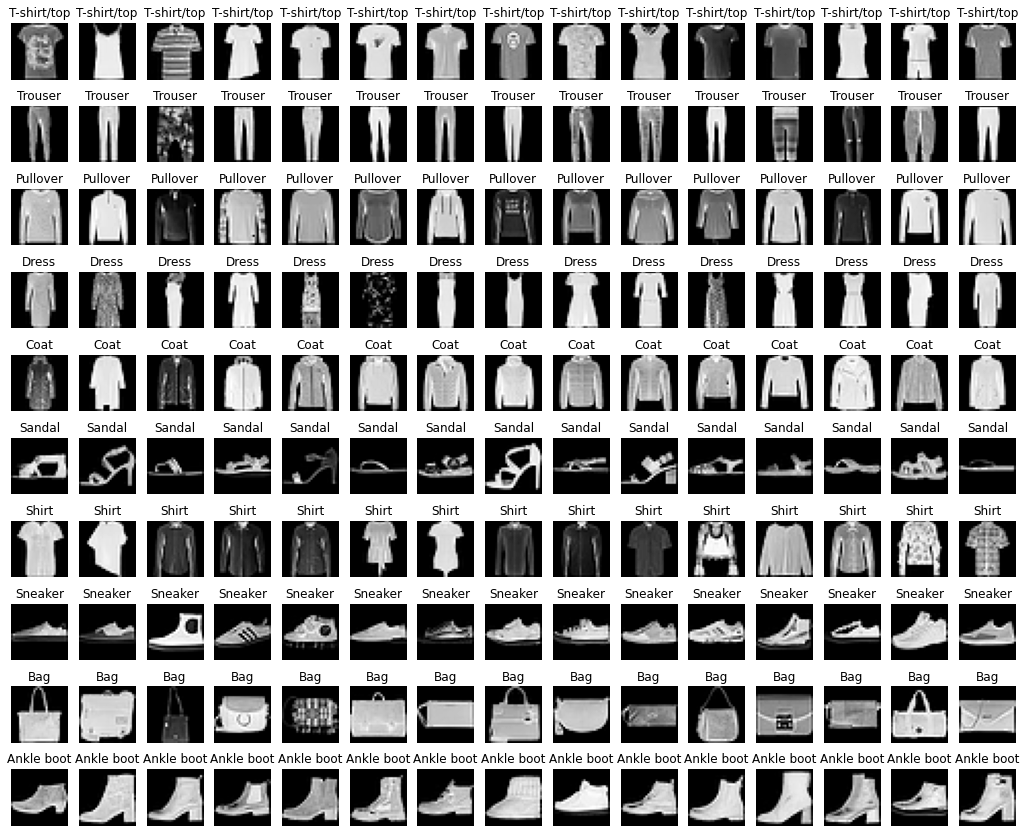

In [20]:
show_samples(15)

####**Helper Function for flattening the images**

In [21]:
def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

####**Preprocessing the data**

In [22]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train/255.0
Y_train = Y_train
X_train = flatten(X_train)
X_test = flatten(X_test)/255.0
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)

####**Training and Testing the Neural Network Model**

In [23]:
model = NN([FNNLayer(784, 32, weight_decay = 0.0005, init_method = 'random'), Tanh(), 
            
            FNNLayer(32, 32, weight_decay = 0.0005, init_method = 'random'), Tanh(),
            FNNLayer(32, 32, weight_decay = 0.0005, init_method = 'random'), Tanh(),
            FNNLayer(32, 32, weight_decay = 0.0005, init_method = 'random'), Tanh(),
            FNNLayer(32, 32, weight_decay = 0.0005, init_method = 'random'), Tanh(),
            FNNLayer(32, 32, weight_decay = 0.0005, init_method = 'random'), Tanh(),

            FNNLayer(32, 10, weight_decay = 0.0005, init_method = 'random')], log_wandb = False)
optimizer = Momentum(learning_rate = 0.001)
loss = LogLoss()
model.compile(loss, optimizer)
model.fit(X_tr, Y_tr, X_val, Y_val, batch_size=32, epochs=5)
model.evaluate(X_test, Y_test)

Epoch: 1 Train Loss: 0.9608727208876507 Train Accuracy: 0.6975155509478673 Validation Loss: 0.5746133544151006 Validation Accuracy: 0.807845744680851
Epoch: 2 Train Loss: 0.5198984769862933 Train Accuracy: 0.8232005331753555 Validation Loss: 0.4656114259838042 Validation Accuracy: 0.8377659574468085
Epoch: 3 Train Loss: 0.4523165208105856 Train Accuracy: 0.8433056872037915 Validation Loss: 0.42625370336594826 Validation Accuracy: 0.8490691489361702
Epoch: 4 Train Loss: 0.4193907585108276 Train Accuracy: 0.8534508293838863 Validation Loss: 0.4103946177491127 Validation Accuracy: 0.8543882978723404
Epoch: 5 Train Loss: 0.39800534988171 Train Accuracy: 0.8606153732227488 Validation Loss: 0.40063669529886536 Validation Accuracy: 0.8583776595744681
Model trained!
Test loss: 0.4350780935655611 Test accuracy: 0.8467


###**Sweep Setup**

In [24]:
activation_funcs = {'sigmoid': Sigmoid, 'tanh': Tanh, 'relu': ReLU, 'leakyrelu': LeakyReLU}

loss_funcs = {'mean_squared_error': MSE, 'cross_entropy': LogLoss}

def optimizer_func(opt, lr):
    optimizer_map = {"sgd": SGD,"momentum":Momentum, "nag": Nesterov, "rmsprop":RMSProp, "adam": Adam, "nadam":NAdam}
    if opt not in optimizer_map:
        raise ValueError("Invalid optimizer name")
    optimizer_class = optimizer_map[opt]
    optimizer = optimizer_class(learning_rate = lr)
    return optimizer

def make_network(num_layers, size_layer, act, reg, init_method):
    layers = []

    layers.extend([FNNLayer(784, size_layer, reg, init_method), activation_funcs[act]()])
    for i in range(num_layers):
        layers.extend([FNNLayer(size_layer,size_layer, reg, init_method), activation_funcs[act]()])
    layers.append(FNNLayer(size_layer, 10, reg, init_method))
    return layers

def preprocess(train, test):
    train = flatten(train)/255.0
    test = flatten(test)/255.0
    return train, test


def sweep():
    defaults = {
        'epochs': 5,
        'num_layers': 3,
        'size_layer': 32,
        'weight_decay': 0,
        'learning_rate': 0.001,
        'init_method': 'xavier',
        'optimizer': 'sgd',
        'batch_size': 16,
        'activation': 'relu',
        'loss': 'cross_entropy'
        }
    wandb.init(config = defaults, magic = True)
    config = wandb.config
    (tr_imgs, tr_labels), (test_imgs, test_labels) = fashion_mnist.load_data()
    tr_imgs, test_imgs = preprocess(tr_imgs, test_imgs)
    X_t, X_v, Y_t, Y_v = train_test_split(tr_imgs, tr_labels, test_size = 0.1, shuffle = True)
    model = NN(make_network(config.num_layers, config.size_layer, config.activation, config.weight_decay, \
                            config.init_method))
    model.compile(loss = loss_funcs[config.loss](), \
                  optimizer = optimizer_func(config.optimizer, config.learning_rate))
    model.fit(X_t, Y_t, X_v, Y_v, batch_size = config.batch_size, epochs = config.epochs)
    name1 = f'ep_{config.epochs}_hl_{config.num_layers}_hlsize_{config.size_layer}_'
    name2 = f'wd_{config.weight_decay}_lr_{config.learning_rate}_winit_{config.init_method}_'
    name3 = f'opt_{config.optimizer}_bs_{config.batch_size}_ac_{config.activation}_loss_{config.loss}'
    sweep_name = name1+name2+name3
    wandb.run.name = sweep_name
    wandb.run.save()
    wandb.run.finish()

In [25]:
hyperparameters = {
      "epochs": {
          'values': [5, 10]
      },
      "num_layers": {
          'values' : [3, 4, 5]
      },
      "size_layer": {
          'values' : [32, 64, 128]
      },
      "weight_decay": {
          'values': [0, 0.0005, 0.001, 0.01]
      },
      "learning_rate":{
        'values': [0.01, 0.001, 0.0001]
      },
      "init_method": {
          'values' : ['random', 'xavier', 'kaiming']
      },
      "optimizer": {
          'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
      },
      "batch_size": {
          'values': [32, 64, 128, 256]
      },
      "activation": {
          'values': ['sigmoid','tanh','relu', 'leakyrelu']
      },
      "loss": {
          'values': ['cross_entropy']
      }
  }

In [26]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'hyperparam_tuning_for_logloss',
    'metric': {
        'goal': 'maximize', 
        'name': "Val Accuracy"
        },
    'parameters': hyperparameters
}

In [27]:
sweep_id = wandb.sweep(sweep_configuration, entity=entity_name, project=project_name)

Create sweep with ID: 3odgr0d7
Sweep URL: https://wandb.ai/sidbetala/cs6910-assignment1/sweeps/3odgr0d7


In [28]:
sweep_id = '3odgr0d7'

In [29]:
wandb.agent(sweep_id, sweep, project = project_name, count = 100)

wandb: Agent Starting Run: b6lq04lg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_layer: 32
wandb: 	weight_decay: 0.1
wandb: Currently logged in as: sidbetala. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Model trained!


Epoch,▁▃▅▆█
Train Accuracy,█▁▁▁▁
Train Loss,▁████
Val Accuracy,▁▁▁▁▁
Val Loss,▁████
Epoch,5
Train Accuracy,0.09914
Train Loss,2.30264
Val Accuracy,0.09574
Val Loss,2.30266


wandb: Agent Starting Run: xoabl6da with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_layer: 32
wandb: 	weight_decay: 0.01


Model trained!


Epoch,▁▃▅▆█
Train Accuracy,▁▅▇██
Train Loss,█▅▃▂▁
Val Accuracy,▁▅▇▇█
Val Loss,█▅▄▂▁
Epoch,5
Train Accuracy,0.6347
Train Loss,1.40494
Val Accuracy,0.63735
Val Loss,1.3608


wandb: Agent Starting Run: a53p85cj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_method: kaiming
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	size_layer: 64
wandb: 	weight_decay: 0


Model trained!


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▃▄▅▆▇████
Train Loss,█▇▆▄▃▂▂▁▁▁
Val Accuracy,▁▃▅▆▇▇████
Val Loss,█▇▅▄▃▂▂▁▁▁
Epoch,10
Train Accuracy,0.68141
Train Loss,0.93583
Val Accuracy,0.68231
Val Loss,0.91508


wandb: Agent Starting Run: dpr5v0us with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	size_layer: 128
wandb: 	weight_decay: 0.0005


Model trained!


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▇▇▇█████
Train Loss,█▄▂▂▂▁▁▁▁▁
Val Accuracy,▁▅▆▇▇█████
Val Loss,█▃▂▂▂▁▁▁▁▁
Epoch,10
Train Accuracy,0.82329
Train Loss,0.49535
Val Accuracy,0.82613
Val Loss,0.48214


wandb: Agent Starting Run: 33q2ijb2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_layer: 64
wandb: 	weight_decay: 0.01


Model trained!


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▁▁▁▃▄▅▅▆█
Train Loss,█▇▇▆▆▅▄▃▂▁
Val Accuracy,▁▁▁▂▃▄▅▅▇█
Val Loss,█▇▇▆▆▅▄▄▂▁
Epoch,10
Train Accuracy,0.41482
Train Loss,1.98621
Val Accuracy,0.45219
Val Loss,1.94711


wandb: Agent Starting Run: qwdpxygs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_layer: 32
wandb: 	weight_decay: 0.001


Model trained!


Epoch,▁▃▅▆█
Train Accuracy,▁▅▆▇█
Train Loss,█▄▂▂▁
Val Accuracy,▁▄▆▇█
Val Loss,█▄▃▂▁
Epoch,5
Train Accuracy,0.76111
Train Loss,0.75656
Val Accuracy,0.77527
Val Loss,0.73002


wandb: Agent Starting Run: 19a13owm with config:
wandb: 	activation: leakyrelu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.1
wandb: 	loss: cross_entropy
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_layer: 64
wandb: 	weight_decay: 0.1


Model trained!


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,█▄▆▅▆▅▄▃▂▁
Train Loss,█▄▃▂▂▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁
Val Loss,█▆▅▄▄▃▂▂▁▁
Epoch,10
Train Accuracy,0.10088
Train Loss,2.30326
Val Accuracy,0.09631
Val Loss,2.30425


wandb: Agent Starting Run: owdt89lc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_method: kaiming
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_layer: 32
wandb: 	weight_decay: 0.1


Model trained!


Epoch,▁▃▅▆█
Train Accuracy,▆▄█▄▁
Train Loss,█▁▁▁▁
Val Accuracy,▁██▆▆
Val Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.09793
Train Loss,2.30271
Val Accuracy,0.09996
Val Loss,2.30275


wandb: Agent Starting Run: ygyruo3o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_method: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_layer: 128
wandb: 	weight_decay: 0


Model trained!


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Val Accuracy,▁▄▆▇█
Val Loss,█▄▃▂▁
Epoch,5
Train Accuracy,0.80091
Train Loss,0.59146
Val Accuracy,0.80219
Val Loss,0.57853


wandb: Agent Starting Run: 7tpu9rtw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_method: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_layer: 128
wandb: 	weight_decay: 0


wandb: Ctrl + C detected. Stopping sweep.
